# Movie Recommendation System

In [2]:
# load necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #Use to optimise the gradient
%matplotlib inline

In [3]:
# load the ratings data
path = 'D:\machine learning\coursera\machine-learning-ex8\ex8\ex8_movies.mat'
moviedata = scipy.io.loadmat(path)
Y = moviedata['Y']  # matrix (nm_movies * nm_users) containing rating of movies
R = moviedata['R']  # binary matrix :R(i,j) = 1 if user j gave a rating to movie i, and R(i; j) = 0 otherwise

# check the shape of the data
nm_movies, nm_users = Y.shape
print('Total no. of movies: '+ str(nm_movies))
print('Total no. of users: '+ str(nm_users))

Total no. of movies: 1682
Total no. of users: 943


Text(0.5,0,'Users (943)')

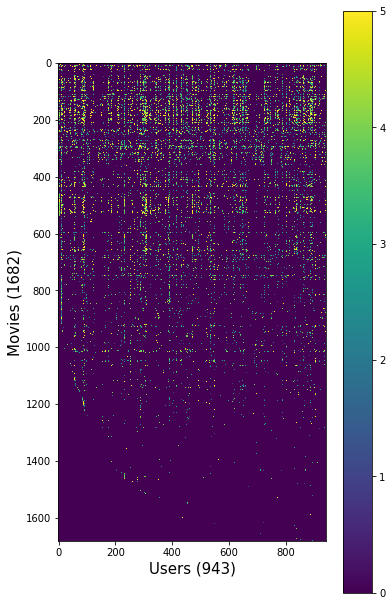

In [4]:
# Visualize the ratings matrix
fig = plt.figure(figsize=(6,6*(1682./943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%nm_movies,fontsize=15)
plt.xlabel('Users (%d)'%nm_users,fontsize=15)

In [5]:
# Read the matrix containing parametrs
path = 'D:\machine learning\coursera\machine-learning-ex8\ex8\ex8_movieParams.mat'
params = scipy.io.loadmat(path)
X = params['X']  # i-th row of X corresponds to the feature vector for the i-th movie
theta = params['Theta']  # i-th row of theta corresponds to one parameter vector for the i-th user
n_features = int(params['num_features'])

# check shape X and theta and n_features
print(X.shape)
print(theta.shape)
print(n_features)

(1682, 10)
(943, 10)
10


In [6]:
# Create utility functions

# This function flattens the matrix into one long array. This is required to use the off-the shelf minimizing functions
def flattenParams(X, theta):
    """
    Input: X and theta (matrices you want to flatten)
    Output: (nm_movies*n_features + nm_users*n_features,1) shaped numpy array
    """
    return np.concatenate((X.flatten(),theta.flatten()))

# This function re-shapes the X and theta back to the original size
def reshapeParams(flattened_Xandtheta, nm_movies, nm_users, n_features):
    assert flattened_Xandtheta.shape[0] == int(nm_movies*n_features+nm_users*n_features)
    
    reX = flattened_Xandtheta[:int(nm_movies*n_features)].reshape((nm_movies, n_features))
    retheta = flattened_Xandtheta[int(nm_movies*n_features):].reshape((nm_users, n_features))
    
    return reX, retheta

# This function calculates the cost function
def cofiCostFunc(params, Y, R, nm_users, nm_movies, n_features, mylambda = 0.):
    
    # Unfold the X and Theta matrices from the flattened params
    X, theta = reshapeParams(params, nm_movies, nm_users, n_features)
  
   # First calculate dot product of theta and X 
    term1 = X.dot(theta.T)
    
    # Then element-wise multiply that matrix by the R matrix
    term1 = np.multiply(term1, R)
    
    # Then subtract the Y- matrix from term1 to calculate the cost
    cost = 0.5 * np.sum( np.square(term1-Y) )
    
    # To calculate the regularized cost
    cost += (mylambda/2.) * np.sum(np.square(theta))
    cost += (mylambda/2.) * np.sum(np.square(X))
    
    return cost

# This function calculates the gradient of the cost function
def cofiGrad(params, Y, R, nm_users, nm_movies, n_features, mylambda = 0.):
    
    # Unfold the X and theta matrices from the flattened params
    X, theta = reshapeParams(params, nm_movies, nm_users, n_features)

    # First the X gradient term 
    term1 = X.dot(theta.T)
    term1 = np.multiply(term1, R)
    # Now subtract the y matrix (which already has 0 for nonrated movies)
    term1 -= Y
    # Lastly dot product with theta
    Xgrad = term1.dot(theta)
    
    # Calculate the theta gradient term
    thetagrad = term1.T.dot(X)

    # Regularization stuff
    Xgrad += mylambda * X
    thetagrad += mylambda * theta
    
    return flattenParams(Xgrad, thetagrad)

# Normalize the ratings
def normalizeRatings(Y, R):
    
    # The mean is only counting movies that were rated
    Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return Y-Ymean, Ymean

In [7]:
# Before we train the model, let's create our own movie ratings to get personalized recommendations.
# The file 'movie_ids' contains the list of the movies that links the movie index to its title.
# Let's load the file into a dictionary

movie_idx = {}
f = open('D:\machine learning\coursera\machine-learning-ex8\ex8/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [8]:
# Start the training
Ynorm, Ymean = normalizeRatings(Y,R)

# Generate random initial parameters, Theta and X
X = np.random.rand(nm_movies,n_features)
theta = np.random.rand(nm_users, n_features)
flat = flattenParams(X, theta)

mylambda = 10.

# Training the actual model with fmin_cg
result = scipy.optimize.fmin_cg(cofiCostFunc, x0=flat, fprime=cofiGrad, \
                               args=(Y,R,nm_users,nm_movies,n_features,mylambda), \
                                maxiter=50,disp=True,full_output=True)

         Current function value: 72914.583144
         Iterations: 50
         Function evaluations: 74
         Gradient evaluations: 74


In [11]:
# Reshape the trained output into sensible "X" and "Theta" matrices
resX, restheta = reshapeParams(result[0], nm_movies, nm_users, n_features)

# After training the model, now make recommendations 
predictions = resX.dot(restheta.T)
my_preds = predictions[:, -1] + Ymean.flatten()
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

array([ 9.36553832,  9.08566851,  9.03780947,  8.95378623,  8.92907933,
        8.90832733,  8.90777044,  8.84211761,  8.81191721,  8.72885782])

In [16]:
# To find the movie index of the above ratings, we use argsort
idx = np.argsort(my_preds, axis=0)[::-1]
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0:0.1f} for movie {1}.'.format((float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 9.4 for movie Pulp Fiction (1994).
Predicted rating of 9.1 for movie Good Will Hunting (1997).
Predicted rating of 9.0 for movie Shawshank Redemption, The (1994).
Predicted rating of 9.0 for movie Titanic (1997).
Predicted rating of 8.9 for movie Usual Suspects, The (1995).
Predicted rating of 8.9 for movie Godfather, The (1972).
Predicted rating of 8.9 for movie Silence of the Lambs, The (1991).
Predicted rating of 8.8 for movie Schindler's List (1993).
Predicted rating of 8.8 for movie Fargo (1996).
Predicted rating of 8.7 for movie One Flew Over the Cuckoo's Nest (1975).


In [17]:
# To print original ratings
idx = np.argsort(ratings, axis=0)[::-1]
print ('Original ratings provided:')
for i in range(10):
    j = int(idx[i])
    print('Rated {0:0.1f} for movie {1}.' .format(float(ratings[j]),movie_idx[j]))

Original ratings provided:
Rated 5.0 for movie Die Hard 2 (1990).
Rated 5.0 for movie Sphere (1998).
Rated 5.0 for movie Forrest Gump (1994).
Rated 5.0 for movie Shawshank Redemption, The (1994).
Rated 5.0 for movie Usual Suspects, The (1995).
Rated 4.0 for movie Toy Story (1995).
Rated 4.0 for movie Outbreak (1995).
Rated 4.0 for movie Alien (1979).
Rated 3.0 for movie While You Were Sleeping (1995).
Rated 3.0 for movie Twelve Monkeys (1995).
